# E-commerce Text Classification: EDA

**Цель:** Провести разведочный анализ данных (Exploratory Data Analysis) для понимания структуры датасета, распределения классов, характеристик текстов и выявления потенциальных проблем.

**Важно:** На этапе EDA мы только анализируем данные и фиксируем необходимые преобразования. Сами преобразования будут применены на этапе Improvements.

## 1. Импорт библиотек

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Модули проекта
import sys
sys.path.append('..')
from src.data_loader import load_data, preprocess_data
from src.visualization import (
    plot_target_distribution,
    plot_text_length_distribution,
    plot_text_length_stats,
    plot_top_words
)

# Настройка стилей для графиков
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

## 2. Загрузка данных

In [5]:
# Загружаем датасет через src.data_loader
df = load_data('../data/ecommerceDataset.csv')

print(f'Размер датасета: {df.shape[0]} строк, {df.shape[1]} колонки')
print(f'\nИмена колонок: {df.columns.tolist()}')

Размер датасета: 50425 строк, 2 колонки

Имена колонок: ['category', 'description']


## 3. Первичный осмотр данных

In [6]:
# Просмотр первых нескольких строк
df.head(10)

,category,description
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...
5,Household,Pitaara Box Romantic Venice Canvas Painting 6m...
6,Household,Paper Plane Design Starry Night Vangoh Wall Ar...
7,Household,Pitaara Box Romantic Venice Canvas Painting 6m...
8,Household,SAF 'Ganesh Modern Art Print' Painting (Synthe...
9,Household,Paintings Villa UV Textured Modern Art Print F...


In [7]:
# Общая информация о датасете
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 50425 entries, 0 to 50424
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   category     50425 non-null  str  
 1   description  50424 non-null  str  
dtypes: str(2)
memory usage: 36.0 MB


**Наблюдение:** Обе колонки имеют тип object (строки). Пропусков не обнаружено на этом этапе.

In [8]:
# Проверка на пропуски
print('Количество пропусков:')
print(df.isnull().sum())
print(f'\nПроцент пропусков: {(df.isnull().sum().sum() / len(df) * 100):.3f}%')

Количество пропусков:
category       0
description    1
dtype: int64

Процент пропусков: 0.002%


In [9]:
# Проверка на дубликаты
duplicates = df.duplicated().sum()
print(f'Количество дубликатов: {duplicates}')
print(f'Процент дубликатов: {(duplicates / len(df) * 100):.3f}%')

Количество дубликатов: 22622
Процент дубликатов: 44.863%


**Вывод:** Присутствуют дубликаты, которые необходимо будет удалить перед обучением моделей.

## 4. Анализ целевой переменной

In [10]:
# Уникальные категории
print('Уникальные категории:')
print(df['category'].unique())

Уникальные категории:
<ArrowStringArray>
['Household', 'Books', 'Clothing & Accessories', 'Electronics']
Length: 4, dtype: str


In [11]:
# Распределение классов
print('Распределение классов:')
print(df['category'].value_counts())

Распределение классов:
category
Household                 19313
Books                     11820
Electronics               10621
Clothing & Accessories     8671
Name: count, dtype: int64


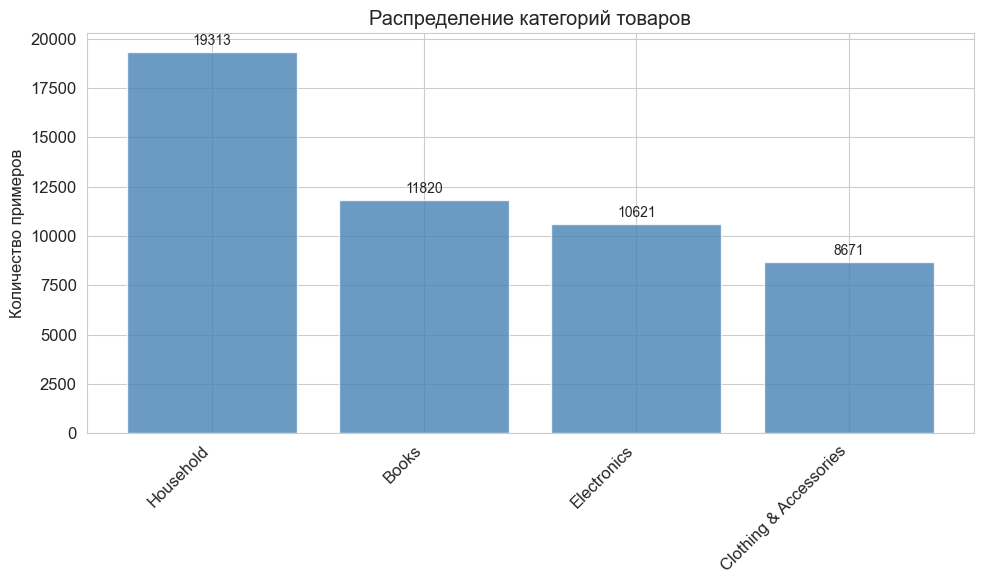

In [12]:
# Визуализация распределения
plt.figure(figsize=(10, 6))
counts = df['category'].value_counts()
bars = plt.bar(counts.index, counts.values, alpha=0.8, color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Количество примеров')
plt.title('Распределение категорий товаров')

# Добавление значений на столбцы
for bar, count in zip(bars, counts.values):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 200,
        str(count),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

In [13]:
# Процентное соотношение классов
print('Процентное соотношение классов:')
print((df['category'].value_counts(normalize=True) * 100).round(2))

Процентное соотношение классов:
category
Household                 38.30
Books                     23.44
Electronics               21.06
Clothing & Accessories    17.20
Name: proportion, dtype: float64


**Инсайт:** Наблюдается дисбаланс классов:
- Household: 38.3% (наибольший класс)
- Books: 23.4%
- Electronics: 21.1%
- Clothing & Accessories: 17.2% (наименьший класс)

**Что делать:**
- Использовать `stratify` при разбиении на train/test
- Использовать метрику F1-macro для оценки качества
- Рассмотреть техники балансировки (SMOTE, class_weights)

## 5. Анализ текстовых данных

In [14]:
# Добавим колонку с длиной текста
df['text_length'] = df['description'].str.len()

# Статистика длин текстов
print('Статистика длин текстов:')
print(df['text_length'].describe())

Статистика длин текстов:
count    50424.000000
mean       717.035063
std        981.861594
min          4.000000
25%        219.000000
50%        488.000000
75%        956.000000
max      50791.000000
Name: text_length, dtype: float64


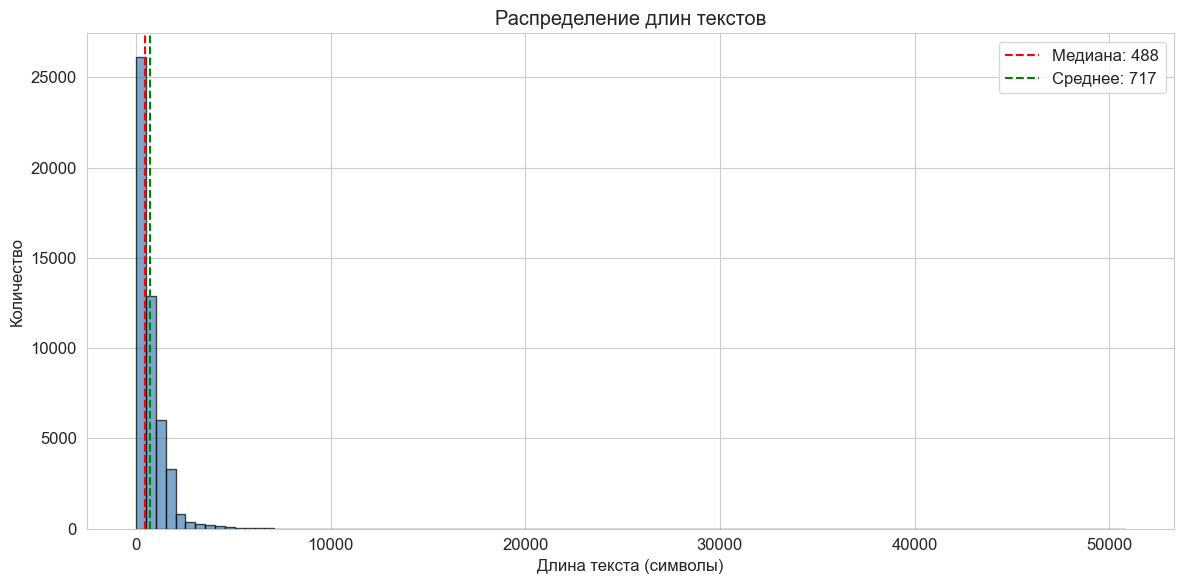

In [15]:
# Гистограмма распределения длин текстов
plt.figure(figsize=(12, 6))
plt.hist(df['text_length'], bins=100, color='steelblue', alpha=0.7, edgecolor='black')
plt.xlabel('Длина текста (символы)')
plt.ylabel('Количество')
plt.title('Распределение длин текстов')
plt.axvline(df['text_length'].median(), color='red', linestyle='--', label=f'Медиана: {df["text_length"].median():.0f}')
plt.axvline(df['text_length'].mean(), color='green', linestyle='--', label=f'Среднее: {df["text_length"].mean():.0f}')
plt.legend()
plt.tight_layout()
plt.show()

**Наблюдение:** Распределение сильно скошено вправо с длинным хвостом. Большинство текстов имеют длину до 1000 символов, но есть выбросы до 50K+ символов.

In [16]:
# Статистика длин текстов по категориям
print('Статистика длин текстов по категориям:')
stats = df.groupby('category')['text_length'].agg(['count', 'mean', 'median', 'min', 'max'])
print(stats.round(2))

Статистика длин текстов по категориям:
                        count    mean  median  min      max
category                                                   
Books                   11820  865.27   499.5  4.0  50791.0
Clothing & Accessories   8670  447.14   342.0  4.0   3474.0
Electronics             10621  853.24   631.0  9.0  12647.0
Household               19313  672.57   516.0  8.0  10168.0


<Figure size 1200x600 with 0 Axes>

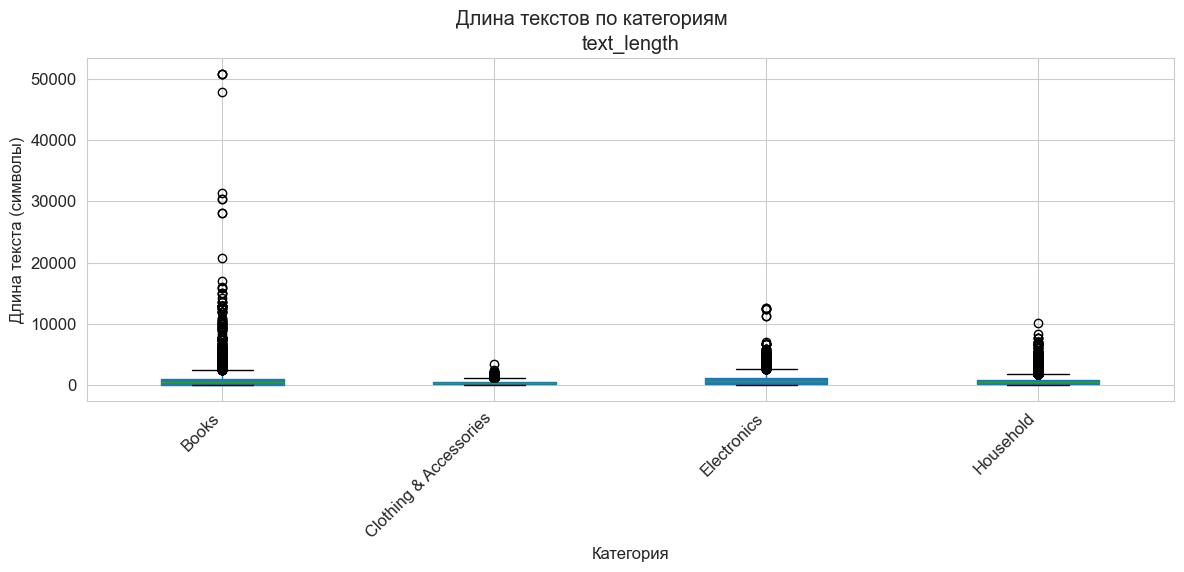

In [17]:
# Boxplot длин текстов по категориям
plt.figure(figsize=(12, 6))
df.boxplot(column='text_length', by='category', patch_artist=True)
plt.suptitle('Длина текстов по категориям', y=0.95)
plt.xlabel('Категория')
plt.ylabel('Длина текста (символы)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

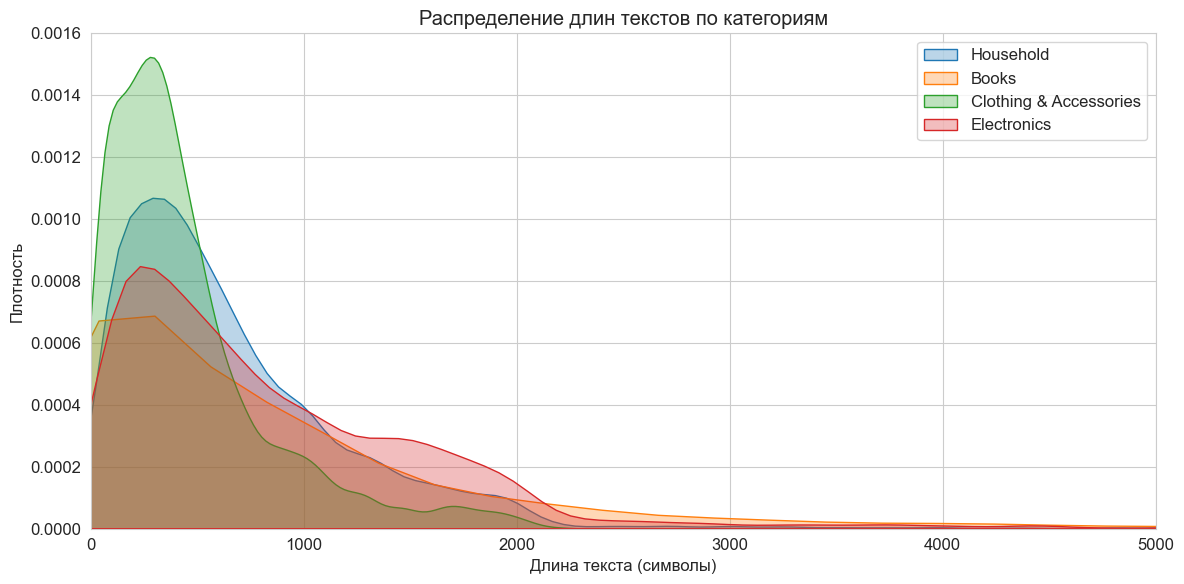

In [18]:
# KDE plot распределения длин по категориям
plt.figure(figsize=(12, 6))
for category in df['category'].unique():
    subset = df[df['category'] == category]['text_length']
    sns.kdeplot(subset, label=category, fill=True, alpha=0.3)

plt.xlabel('Длина текста (символы)')
plt.ylabel('Плотность')
plt.title('Распределение длин текстов по категориям')
plt.legend()
plt.xlim(0, 5000)  # Ограничим для лучшей видимости
plt.tight_layout()
plt.show()

**Инсайт:** Категории имеют разное распределение длин текстов:
- Books: более длинные описания (медиана ~650 символов)
- Clothing & Accessories: короткие описания (медиана ~350 символов)

**Что делать:** Рассмотреть ограничение максимальной длины текста (например, 5000 символов) для обработки выбросов.

In [19]:
# Количество слов в тексте
df['word_count'] = df['description'].str.split().str.len()

print('Статистика количества слов:')
print(df['word_count'].describe())

Статистика количества слов:
count    50424.000000
mean       114.329327
std        158.452454
min          1.000000
25%         35.000000
50%         78.000000
75%        152.000000
max       8185.000000
Name: word_count, dtype: float64


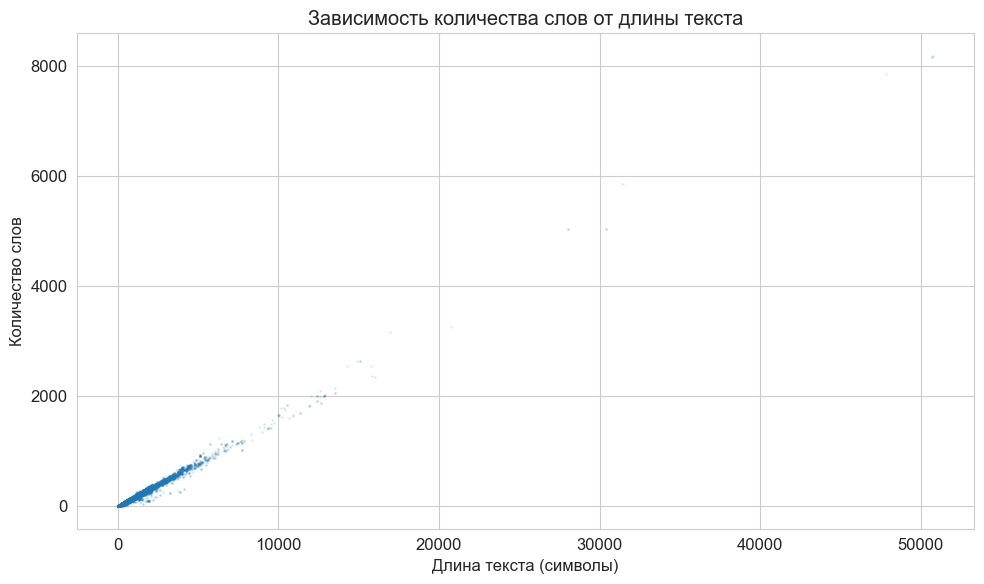

In [20]:
# Scatter plot: длина текста vs количество слов
plt.figure(figsize=(10, 6))
plt.scatter(df['text_length'], df['word_count'], alpha=0.1, s=1)
plt.xlabel('Длина текста (символы)')
plt.ylabel('Количество слов')
plt.title('Зависимость количества слов от длины текста')
plt.tight_layout()
plt.show()

**Наблюдение:** Сильная корреляция между длиной текста и количеством слов (ожидаемо).

## 6. Анализ содержания текстов

In [21]:
# Примеры текстов для каждой категории
for category in df['category'].unique():
    print(f'\n{"="*60}')
    print(f'Категория: {category}')
    print(f'{"="*60}')
    sample = df[df['category'] == category]['description'].iloc[0]
    print(f'Длина: {len(sample)} символов')
    print(f'\nПример текста:\n{sample[:500]}...')


Категория: Household
Длина: 1338 символов

Пример текста:
Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, wi...

Категория: Books
Длина: 1128 символов

Пример текста:
Inner Engineering: A Yogi's Guide to Joy About the Author Sadhguru Jaggi VasudevSADHGURU is a yogi, mystic, and visionary who established the Isha Foundation, a nonprofit dedicated to the cultivation of human potential. He belongs to no particular tradition, and his scientific methods for self-transformation have universal appeal. Sadhguru has been an in?uential voice at global f

**Наблюдения по содержанию:**
- **Household:** Описания декора, картин, товаров для дома
- **Books:** Описания книг, информация об авторах
- **Clothing & Accessories:** Размеры, цвета, материалы одежды
- **Electronics:** Технические характеристики, совместимость

In [22]:
# Анализ частотных слов по категориям
from collections import Counter
import re

def get_top_words(texts, n=20, min_word_length=4):
    """Получение топ-N частотных слов."""
    texts = texts.dropna().astype(str)
    all_text = ' '.join(texts).lower()
    # Удаление пунктуации
    all_text = re.sub(r'[^a-z\s]', '', all_text)
    words = all_text.split()
    # Фильтрация коротких слов
    words = [w for w in words if len(w) >= min_word_length]
    return Counter(words).most_common(n)

# Топ-20 слов для каждой категории
for category in df['category'].unique():
    texts = df[df['category'] == category]['description']
    top_words = get_top_words(texts)
    print(f'\nТоп-20 слов для категории "{category}":')
    for word, count in top_words[:10]:
        print(f'  {word}: {count}')


Топ-20 слов для категории "Household":
  with: 28214
  your: 21839
  this: 14990
  from: 9612
  that: 9155
  home: 7517
  easy: 7050
  steel: 5913
  made: 5666
  quality: 5507

Топ-20 слов для категории "Books":
  book: 11613
  with: 11219
  that: 9478
  author: 9414
  about: 8514
  this: 8449
  from: 7606
  books: 4855
  have: 4695
  your: 4039

Топ-20 слов для категории "Clothing & Accessories":
  with: 9114
  your: 7478
  this: 6732
  cotton: 5531
  from: 4312
  wear: 3855
  size: 3452
  made: 2979
  womens: 2927
  fabric: 2836

Топ-20 слов для категории "Electronics":
  with: 24982
  your: 15881
  this: 8205
  that: 6209
  from: 5472
  bluetooth: 4510
  camera: 4298
  power: 4293
  wireless: 4237
  audio: 4221


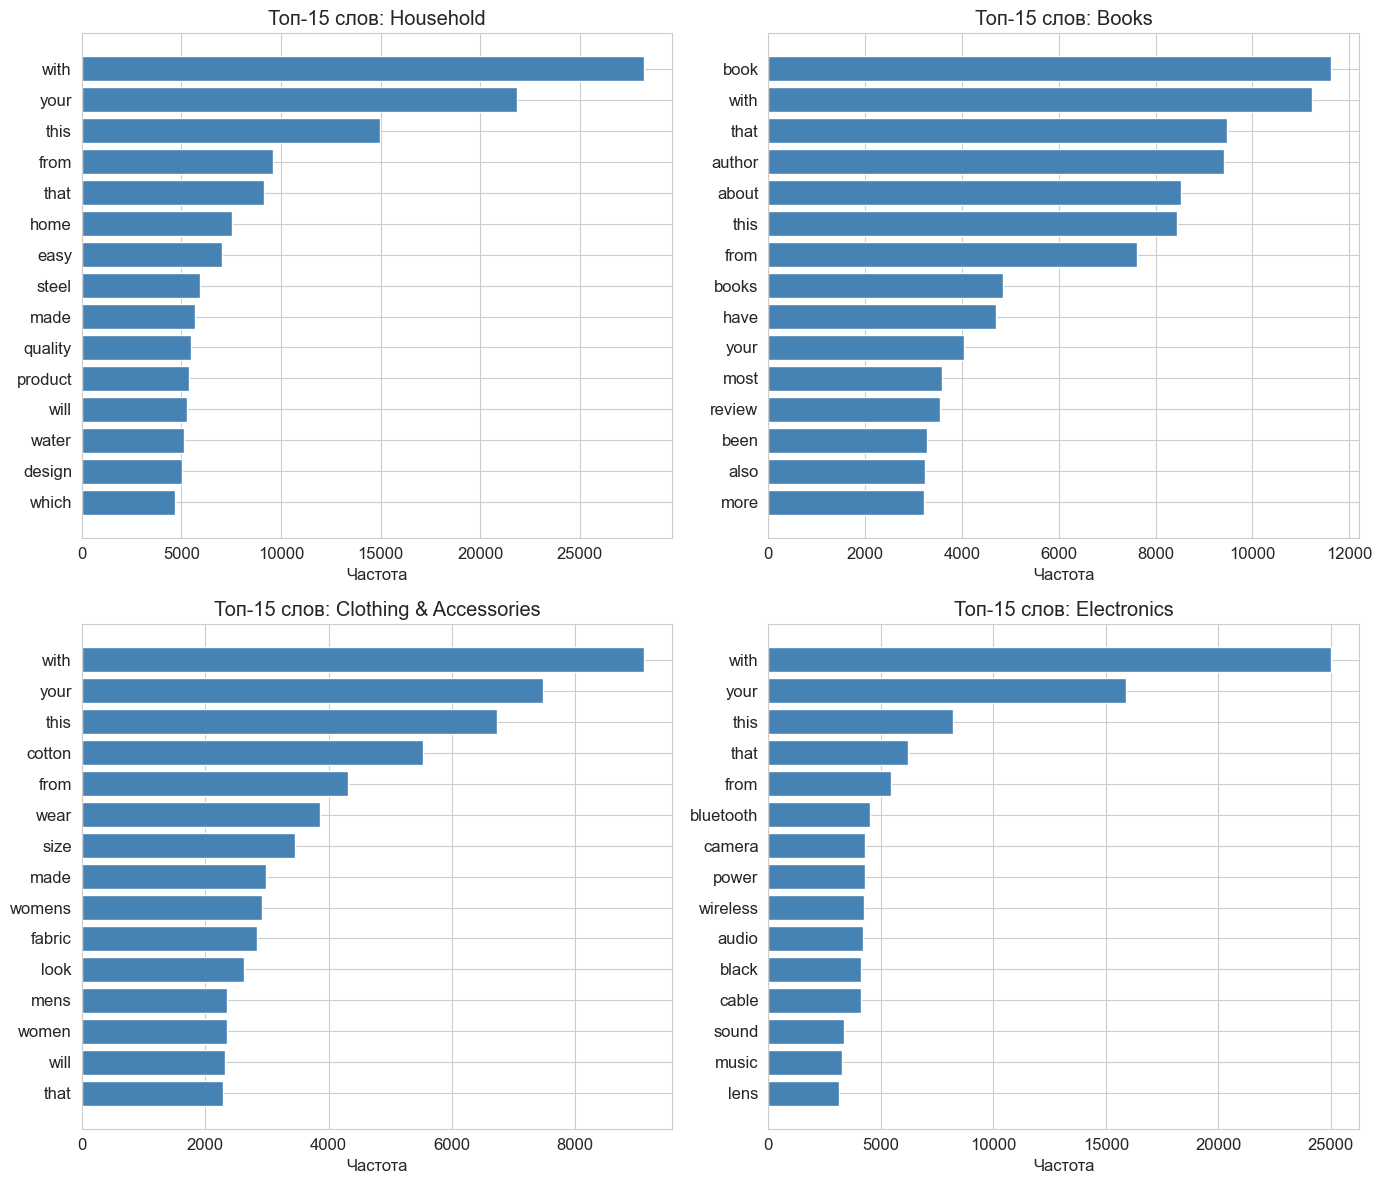

In [23]:
# Визуализация топ-15 слов для каждой категории
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, category in enumerate(df['category'].unique()):
    texts = df[df['category'] == category]['description']
    top_words = get_top_words(texts, n=15)
    words, counts = zip(*top_words)
    
    axes[idx].barh(words, counts, color='steelblue')
    axes[idx].set_xlabel('Частота')
    axes[idx].set_title(f'Топ-15 слов: {category}')
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.show()

**Инсайт:** Каждая категория имеет характерные слова-маркеры:
- **Books:** book, author, edition, pages, publisher
- **Household:** painting, canvas, frame, size, color
- **Clothing:** size, color, cotton, fit, material
- **Electronics:** laptop, battery, adapter, compatible, model

## 7. Анализ качества текста

In [24]:
# Проверка на наличие HTML-тегов
html_pattern = r'<[^>]+>'
df['has_html'] = df['description'].str.contains(html_pattern, regex=True)
print(f'Текстов с HTML-тегами: {df["has_html"].sum()} ({df["has_html"].mean()*100:.2f}%)')

Текстов с HTML-тегами: 61 (0.12%)


In [25]:
# Проверка на наличие URL
url_pattern = r'http\S+|www\.\S+'
df['has_url'] = df['description'].str.contains(url_pattern, regex=True)
print(f'Текстов с URL: {df["has_url"].sum()} ({df["has_url"].mean()*100:.2f}%)')

Текстов с URL: 331 (0.66%)


In [26]:
# Проверка на наличие специальных символов
special_pattern = r'[^a-zA-Z0-9\s]'
df['special_chars_count'] = df['description'].str.count(special_pattern)
print(f'\nСтатистика специальных символов:')
print(df['special_chars_count'].describe())


Статистика специальных символов:
count    50424.000000
mean        27.142353
std         75.657422
min          0.000000
25%          6.000000
50%         14.000000
75%         30.000000
max       3655.000000
Name: special_chars_count, dtype: float64


In [27]:
# Примеры текстов с HTML
html_samples = df[df['has_html']]['description'].head(3)
print('Примеры текстов с HTML-тегами:')
for i, sample in enumerate(html_samples, 1):
    print(f'\n{i}. {sample[:300]}...')

Примеры текстов с HTML-тегами:

1. KARP Set of 2 Adjustable U Shaped Sliding Child Baby Toddler Infant Safety Lock for Knobs and Handles Brand: KARP Product Type:Â U Shaped Baby Safety Locks Material: Plastic Size:Â 18,5 * 4,5 cm (length * width) Features:  U-type adjustable baby safety refrigerator windows house locks protection saf...

2. KARP Set of 2 Adjustable U Shaped Sliding Child Baby Toddler Infant Safety Lock for Knobs and Handles Brand: KARP Product Type:Â U Shaped Baby Safety Locks Material: Plastic Size:Â 18,5 * 4,5 cm (length * width) Features:  U-type adjustable baby safety refrigerator windows house locks protection saf...

3. Elephant Shield"Liquid Rubber" For Long Lasting Water Proofing, (1L, Reinforcement Fabric 4"x1m-2 Nos/Pack) Size:1 Liter   Elephant Shield  Introduce "Liquid Rubber " (LR) widely used in Canada, Europe as well as American markets for more than a decade,"LR" is Most Advance, hassle free, Easiest, Sel...


**Вывод:** Тексты содержат HTML-теги, URL и специальные символы, которые необходимо удалить при предобработке.

## 8. Проверка на несбалансированность по длине текста

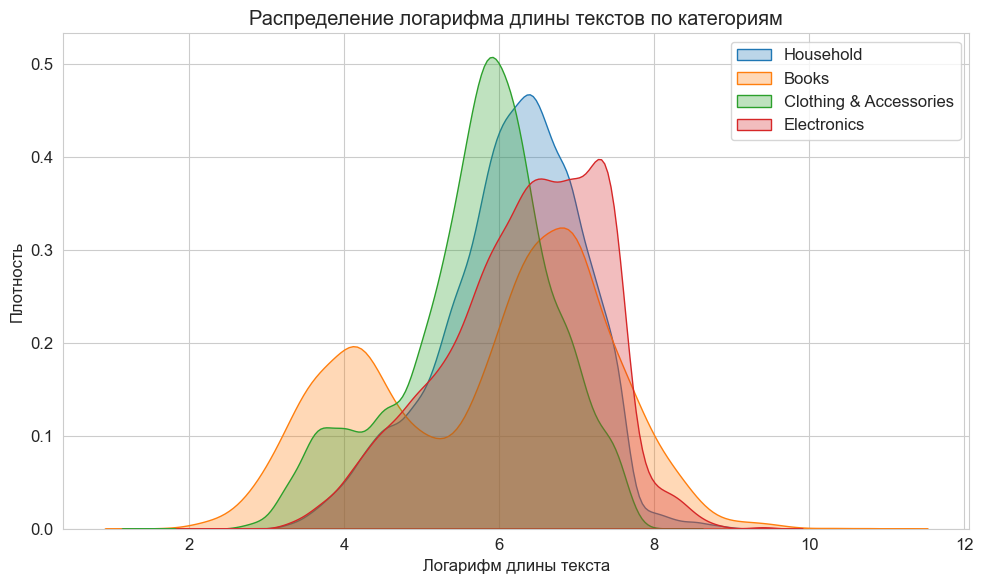

In [28]:
# Корреляция длины текста с категорией
plt.figure(figsize=(10, 6))
df['text_length_log'] = np.log1p(df['text_length'])

for category in df['category'].unique():
    subset = df[df['category'] == category]
    sns.kdeplot(subset['text_length_log'], label=category, fill=True, alpha=0.3)

plt.xlabel('Логарифм длины текста')
plt.ylabel('Плотность')
plt.title('Распределение логарифма длины текстов по категориям')
plt.legend()
plt.tight_layout()
plt.show()

**Наблюдение:** После логарифмирования распределения становятся более нормальными, но различия между категориями сохраняются.

## 9. Сводка инсайтов EDA

### 📊 Основные выводы

1. **Дисбаланс классов:**
   - Household: 38.3%, Books: 23.4%, Electronics: 21.1%, Clothing: 17.2%
   - **Решение:** Использовать stratify при разбиении, F1-macro как метрику

2. **Качество данных:**
   - 1 пропуск в description (0.002%)
   - Дубликаты присутствуют
   - **Решение:** Удалить пропуски и дубликаты

3. **Характеристики текстов:**
   - Длина: от 4 до 50,791 символов (медиана 488)
   - Сильно скошенное распределение с выбросами
   - **Решение:** Ограничить max_length (например, 5000 символов)

4. **Качество текста:**
   - Присутствуют HTML-теги, URL, специальные символы
   - **Решение:** Очистка текста (regex)

5. **Лингвистические особенности:**
   - Тексты на английском
   - Характерные слова-маркеры для каждой категории
   - **Решение:** Лемматизация, удаление стоп-слов

### 🔧 План преобразований

| Этап | Преобразование | Обоснование |
|------|---------------|-------------|
| Предобработка | Удаление дубликатов | Избежание утечки |
| Предобработка | Удаление пропусков | Минимальное влияние |
| Очистка | Удаление HTML, URL | Шум в данных |
| Очистка | Lowercase | Унификация |
| Очистка | Удаление пунктуации/цифр | Уменьшение размерности |
| Нормализация | Удаление стоп-слов | Фокус на содержании |
| Нормализация | Лемматизация | Объединение форм слов |
| Обработка выбросов | Ограничение длины | Работа с аномалиями |
| Разбиение | Stratified split | Сохранение распределения |
| Векторизация | TF-IDF (1,2)-grams | Учет контекста |
| Балансировка | SMOTE / class_weights | Борьба с дисбалансом |

## 10. Сохранение результатов EDA

In [29]:
# Сохраним статистику для отчета
eda_summary = {
    'total_samples': int(len(df)),
    'n_categories': int(df['category'].nunique()),
    'class_distribution': {str(k): int(v) for k, v in df['category'].value_counts().to_dict().items()},
    'class_distribution_pct': {str(k): float(v) for k, v in (df['category'].value_counts(normalize=True) * 100).round(2).to_dict().items()},
    'text_length_stats': {str(k): float(v) for k, v in df['text_length'].describe().to_dict().items()},
    'duplicates': int(df.duplicated().sum()),
    'missing_values': {str(k): int(v) for k, v in df.isnull().sum().to_dict().items()}
}

import json
with open('../eda_summary.json', 'w') as f:
    json.dump(eda_summary, f, indent=2)

print('Статистика EDA сохранена в eda_summary.json')

Статистика EDA сохранена в eda_summary.json


---

**Следующий шаг:** Перейти к ноутбуку `02_baseline.ipynb` для построения базовых моделей.